### Test Docling

In [1]:
from docling.document_converter import DocumentConverter

file = '../../data/papers/Zhang et al. - 2024 - Benchmarking the Text-to-SQL Capability of Large L.pdf'
converter = DocumentConverter()
document = converter.convert(file)

print(document.document.origin.filename)

c:\Users\Arm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\cpp_extension.py:382: UserWarning: Error checking compiler version for cl: [WinError 2] The system cannot find the file specified
  warnings.warn(f'Error checking compiler version for {compiler}: {error}')
c:\Users\Arm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Could not load the custom kernel for multi-scale deformable attention: Command '['where', 'cl']' returned non-zero exit status 1.
Could not load the custom kernel for multi-scale deformable attention: DLL load failed while importing MultiScaleDeformableAttention: The specified module could not be found.
Could not load the custom kernel for multi-scale deformable attention: DLL load failed while importing Mult

Zhang et al. - 2024 - Benchmarking the Text-to-SQL Capability of Large L.pdf


In [27]:
print(document.document)

schema_name='DoclingDocument' version='1.5.0' name='Rajkumar et al. - 2022 - Evaluating the Text-to-SQL Capabilities of Large L' origin=DocumentOrigin(mimetype='application/pdf', binary_hash=2355541156686147883, filename='Rajkumar et al. - 2022 - Evaluating the Text-to-SQL Capabilities of Large L.pdf', uri=None) furniture=GroupItem(self_ref='#/furniture', parent=None, children=[], content_layer=<ContentLayer.FURNITURE: 'furniture'>, name='_root_', label=<GroupLabel.UNSPECIFIED: 'unspecified'>) body=GroupItem(self_ref='#/body', parent=None, children=[RefItem(cref='#/texts/0'), RefItem(cref='#/texts/1'), RefItem(cref='#/texts/2'), RefItem(cref='#/texts/3'), RefItem(cref='#/texts/4'), RefItem(cref='#/texts/5'), RefItem(cref='#/tables/0'), RefItem(cref='#/texts/6'), RefItem(cref='#/texts/7'), RefItem(cref='#/texts/8'), RefItem(cref='#/texts/9'), RefItem(cref='#/texts/10'), RefItem(cref='#/texts/11'), RefItem(cref='#/texts/12'), RefItem(cref='#/texts/13'), RefItem(cref='#/texts/14'), RefIte

### Test Chunking

In [3]:
from docling.chunking import HybridChunker
from docling_core.transforms.chunker.tokenizer.huggingface import HuggingFaceTokenizer
from transformers import AutoTokenizer

TOKENIZER_MODEL="intfloat/multilingual-e5-large-instruct"
MAX_TOKENS=512

tokenizer = HuggingFaceTokenizer(
        tokenizer=AutoTokenizer.from_pretrained(TOKENIZER_MODEL),
        max_tokens=MAX_TOKENS,
    )

chunker = HybridChunker(
    tokenizer=tokenizer,
    merge_peers=True
)

chunk_iter = chunker.chunk(dl_doc=document.document)
chunks = list(chunk_iter)

# for idx, chunk in enumerate(chunks):
#     with open(f"test_data/chunks/chunk_{idx}.txt", "w", encoding="utf-8") as f:
#         f.write(chunk.text)

Token indices sequence length is longer than the specified maximum sequence length for this model (557 > 512). Running this sequence through the model will result in indexing errors


In [9]:
len(chunks)

77

In [11]:
# Checking the documents metadata
chunks[0].model_dump()['meta']

{'schema_name': 'docling_core.transforms.chunker.DocMeta',
 'version': '1.0.0',
 'doc_items': [{'self_ref': '#/texts/2',
   'parent': {'cref': '#/body'},
   'children': [],
   'content_layer': <ContentLayer.BODY: 'body'>,
   'label': <DocItemLabel.TEXT: 'text'>,
   'prov': [{'page_no': 1,
     'bbox': {'l': 142.048,
      't': 724.8820146484375,
      'r': 455.715,
      'b': 712.6010146484375,
      'coord_origin': <CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>},
     'charspan': (0, 61)}]},
  {'self_ref': '#/texts/3',
   'parent': {'cref': '#/body'},
   'children': [],
   'content_layer': <ContentLayer.BODY: 'body'>,
   'label': <DocItemLabel.TEXT: 'text'>,
   'prov': [{'page_no': 1,
     'bbox': {'l': 72.983,
      't': 710.9350146484375,
      'r': 525.283,
      'b': 698.6730146484375,
      'coord_origin': <CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>},
     'charspan': (0, 93)},
    {'page_no': 1,
     'bbox': {'l': 138.186,
      't': 693.0410146484376,
      'r': 460.079,
      'b': 672.0820

In [4]:
processed_chunks = [
    {
        "text": chunk.text,
        "metadata": {
            "filename": chunk.meta.origin.filename,
            "page_numbers": [
                page_no
                for page_no in sorted(
                    set(
                        prov.page_no
                        for item in chunk.meta.doc_items 
                        for prov in item.prov
                    )
                )
            ] or None,
            "title": chunk.meta.headings[0] if chunk.meta.headings else None
        },
    }
    for chunk in chunks
]

In [5]:
processed_chunks

[{'text': 'Bin Zhang 1 , 2 , 3 , ∗ Yuxiao Ye 1 , 4 , ∗ Guoqing Du 1 , ∗ Xiaoru Hu 1 , ∗ Zhishuai Li 1 Sun Yang 1 Chi Harold Liu 4 Rui Zhao 1 Ziyue Li 1 Hangyu Mao 1 , B\n1 Sensetime Research\n3\n4\n2 Institute of Automation, Chinese Academy of Sciences School of Artificial Intelligence, University of Chinese Academy of Sciences School of Computer Science and Technology, Beijing Institute of Technology',
  'metadata': {'filename': 'Zhang et al. - 2024 - Benchmarking the Text-to-SQL Capability of Large L.pdf',
   'page_numbers': [1],
   'title': 'Benchmarking the Text-to-SQL Capability of Large Language Models: A Comprehensive Evaluation'}},
 {'text': "Large Language Models (LLMs) have emerged as a powerful tool in advancing the Text-to-SQL task, significantly outperforming traditional methods. Nevertheless, as a nascent research field, there is still no consensus on the optimal prompt templates and design frameworks. Additionally, existing benchmarks inadequately explore the performance

### Test LanceDB

In [7]:
import lancedb
from lancedb.embeddings import get_registry
from lancedb.pydantic import LanceModel, Vector
from typing import List, Optional, Dict, Any
db = lancedb.connect("data/lancedb")

func = get_registry().get("huggingface").create(name="intfloat/multilingual-e5-large-instruct")

class ChunkMetadata(LanceModel):
    filename: str | None
    page_numbers: List[int] | None
    title: str | None

class Chunks(LanceModel):
    text: str = func.SourceField()
    vector: Vector(func.ndims()) = func.VectorField()
    metadata: ChunkMetadata

table = db.create_table("docling", schema=Chunks, mode="overwrite")

In [8]:
table.add(processed_chunks)

AddResult(version=2)

In [24]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

df = table.to_pandas()
df = df[df['text'].str.contains("outperforms")]
df

,text,vector,metadata
12,"Table 1: EX (%) of different LLMs on open source datasets.\n\nSpider Dev, SQLCoder-34B = 65.00. Spider Dev, InternLM-70B = 67.40. Spider Dev, Codellama-34B = 71.60. Spider Dev, LLama2-Chat-70B = 54.70. BIRD Dev, SQLCoder-34B = 32.07. BIRD Dev, InternLM-70B = 29.60. BIRD Dev, Codellama-34B = 28.29. BIRD Dev, LLama2-Chat-70B = 20.60\nWe conduct a preliminary assessment of the performance of various LLMs on multiple open-source datasets. As depicted in Table 1, the performance of LLMs varies inconsistently across different datasets. Specifically, on the Spider dataset, Codellama-34B outperforms InternLM-70B and SQLCoder-34B, while on the Bird dataset, SQLCoder-34B surpasses InternLM-70B and Codellama34B. On the one hand, there may be differences in the problem types that different LLMs excel at handling. On the other hand, considering that LLMs learn and train from large corpora, these findings suggest that the performance discrepancies observed could be attributed to the potential utilization of open source datasets during the fine-tuning process for coding-specific LLMs. This poses challenges in ensuring the reliability of evaluation results obtained on these datasets.\nTo address the potential overfitting of LLMs, particularly those specialized in coding tasks, and to ensure a reliable and accurate assessment of their capabilities, we construct a novel dataset, termed 'BigTable-0.2k'. This dataset is an extension and augmentation of the BIRD dataset, which is a recently released and widely acknowledged benchmark for evaluating Text-to-SQL parsing.","[0.027962584, 0.25243467, -0.5400942, -0.82305384, 0.88327926, -0.5830705, -0.65958625, 1.1464406, 0.8524913, -0.60683084, 0.117731035, 0.29837212, -0.63212043, 0.057734385, -0.40318486, 0.2630489, -1.3218074, 0.27810034, -0.87840277, -0.7726953, 0.5738023, -0.30739337, -0.17185625, -0.3829441, -0.05838258, -0.4462805, -0.7247751, -0.7860935, -0.40252987, -0.21281002, 0.045836378, 0.005284505, 0.3725937, -0.61597073, -0.707466, 0.22136094, 0.39609453, 0.5163683, -1.1311934, 0.4496448, -0.111432, 0.7286361, 0.58602285, -0.34609511, -0.08251102, 0.16589373, 0.4678143, -0.28300938, -0.44494343, 0.54565895, 0.4839288, -0.27828994, -0.4459471, -0.5801447, -0.28458133, 0.44946185, -1.0115482, 0.72574437, -0.43868968, 0.074569575, -0.29975158, 0.57159483, 0.3142379, -0.3767553, -0.07776551, 0.24950857, 0.026134193, 0.35266528, -0.21688776, 0.20400544, -0.525729, 0.06536093, -0.26040938, -0.2949772, -0.7281132, -0.27915958, 0.68197393, -0.27041918, 0.42715225, -0.09854117, 0.99294966, -0.24371284, 0.36933708, -0.34545603, -0.0057068556, 0.65011865, 0.5270122, -0.06278668, 0.5223725, 0.51995766, -0.022228716, 0.6177351, 0.5649821, -0.24383661, -0.3684726, -0.21117364, 0.12842987, 0.560213, -0.43058044, -0.31762785, ...]","{'filename': 'Zhang et al. - 2024 - Benchmarking the Text-to-SQL Capability of Large L.pdf', 'page_numbers': [5], 'title': '3.3 Dataset Construction'}"
19,"InternLM-70B = 61.7. SimpleDDL-MD-Complete, Llama2-Chat-70B = 50.2\nThese features are combined to form a complete prompt template P , and more details of these representations can be found in Appendix A.1. We test these templates on Spider dev set. As shown in Table 3, 'SimpleDDL-MD-Chat' (see Listing 4) consistently outperforms all other prompts when applied to all 5 backbone LLMs. To this end, we consistently utilize the prompt template 'SimpleDDL-MD-Chat' throughout the subsequent evaluations in this paper.\nCore Conclusion 1. The prompt template 'SimpleDDL-MD-Chat' achieves optimal performance in the Text-to-SQL task.","[0.17184529, 0.2246632, -0.4653119, -0.73726106, 0.83921945, -0.8898838, -0.53048956, 0.97759473, 1.0711998, -0.663497, 0.16047996, 0.53602004, -0.4869531, -0.11312446, -0.5770844, -0.13526739, -1.6639594, 0.59207195, -0.5081308, -0.2789455, 0.7653357, -0.09787293, -0.32791793, -0.40700862, -0.36185062, -0.46796227, -1.1275986, -0.9444025, -0.57153594, -0.35574684, -0.39896

### Test LanceDB from local store

In [95]:
import lancedb
from lancedb.rerankers import LinearCombinationReranker

db = lancedb.connect("../../data/lancedb")
table = db.open_table("docling")

In [96]:
query = "Which prompt template gave the highest zero-shot accuracy on Spider in Zhang et al. (2024)?"
table.create_fts_index("text", replace=True)
reranker = LinearCombinationReranker()
results = table.search(query, query_type="hybrid").rerank(reranker=reranker).limit(10).to_list()

In [97]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
results

[{'text': "First, we observe that incorporating table relationships and content in the prompts remains crucial for effectively prompting Codex in the cross-domain setting. This is not surprising, as Codex cannot directly learn knowledge specific to the test database from the out-of-domain demonstrations. Furthermore, we find that Codex continues to exhibit sensitivity to the representation of table content. Despite having demonstration databases that mirror the construction of the test database, Codex still displays a preference for SelectRow and SelectCol when presenting table content, compared to InsertCol .\nconducting a comprehensive evaluation of prompt representations across different text-to-SQL settings. While there are similar motivations to the work by Rajkumar et al. (2022), which analyzes the performance of CodeX on Spider for the zero-shot setting and on two databases for the single-domain setting, we aim to provide more general findings by evaluating across a wider range 

In [98]:
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage

load_dotenv()

context=[]
for doc in results:
    context.append(doc['text'])
print(context)
query = "Which prompt template gave the highest zero-shot accuracy on Spider in Zhang et al. (2024)?"
messages = [SystemMessage(content=f"Answer question based on context:\n{context}"),
            HumanMessage(content=query)
]

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)
print(llm.invoke(messages).pretty_print())

["First, we observe that incorporating table relationships and content in the prompts remains crucial for effectively prompting Codex in the cross-domain setting. This is not surprising, as Codex cannot directly learn knowledge specific to the test database from the out-of-domain demonstrations. Furthermore, we find that Codex continues to exhibit sensitivity to the representation of table content. Despite having demonstration databases that mirror the construction of the test database, Codex still displays a preference for SelectRow and SelectCol when presenting table content, compared to InsertCol .\nconducting a comprehensive evaluation of prompt representations across different text-to-SQL settings. While there are similar motivations to the work by Rajkumar et al. (2022), which analyzes the performance of CodeX on Spider for the zero-shot setting and on two databases for the single-domain setting, we aim to provide more general findings by evaluating across a wider range of databa

### Test Agents

In [6]:
from langgraph.prebuilt import create_react_agent
from langchain.chat_models import init_chat_model
from langchain.tools import tool
from langchain_tavily import TavilySearch
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
import lancedb

load_dotenv()
# model = init_chat_model(
#     model = "llama3.1:8b",
#     temperature = 0,
#     model_provider = "ollama"
# )

model = init_chat_model(
    model = "gemini-2.5-flash",
    temperature = 0,
    model_provider= "google_genai"
)

# create pdf search tool
@tool("search_vectorDB")
def search_vectorDB(query: str) -> str:
    """
    Search the LanceDB 'docling' table for relevant context.
    Args:
        query: The search query text.
        num_results: The number of top results to return.
    Returns:
        A string containing the top matching chunks.
    """
    db = lancedb.connect("../../data/lancedb")
    table = db.open_table(name="docling")

    results_df = table.search(query).limit(10).to_pandas()
    contexts = []
    for _, row in results_df.iterrows():
        filename = row["metadata"]["filename"]
        page_numbers = row["metadata"]["page_numbers"]
        title = row["metadata"]["title"]

        source_parts = []
        if filename:
            source_parts.append(filename)
            
        if page_numbers:
            source_parts.append(f"p. {', '.join(str(p) for p in page_numbers)}")
        source = f"\nSource: {' - '.join(source_parts)}"

        if title:
            source += f"\nTitle: {title}"

        contexts.append(f"{row['text']}{source}")
    
    return "\n\n".join(contexts)

# supervisor_agent = create_supervisor(
#     [pdf_agent, web_agent],
#     model=model,
#     prompt=(
#         """
#             You are a supervisor who manages two agents.
#             Search for information from pdf using pdf_agent.
#             If information are not found in pdf_agent use web_agent to search for information instead.
#         """
#     )
# )

# input_message = {"role": "user", "content": "Hi!"}
# response = web_agent.invoke({"messages": [input_message]})

# for message in response["messages"]:
#     message.pretty_print()


In [7]:
from langchain_community.tools import DuckDuckGoSearchRun
search_tool = DuckDuckGoSearchRun()

In [8]:
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import MessagesState, END
from langgraph.types import Command

from typing import Literal

def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        "Use pdf_agent first to search for information. If you have found relevant information make it the final answer."
        "If relevant information are not found, use web_agent to search information on website instead."
        "If you or any of the other assistants have the final answer or deliverable,"
        "prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

# create pdf agent
pdf_agent = create_react_agent(model=model,
                               tools=[search_vectorDB],
                               prompt=make_system_prompt("You task is to search for information from pdf (stored as vectorDB) and use it to answer the question."))

# create web agent
web_agent = create_react_agent(
    model=model,
    tools=[search_tool],
    prompt=make_system_prompt(
        "Your task is to search for information and display information found on website."
    )
)

clarification_agent = create_react_agent(model=model,
                                         tools=[],
                                         prompt="Your task is to detect questions that are ambiguous or vague."
                                                "For example: if the user asked 'How many examples are enough for good accuracy?'"
                                                "If the question is too vague then ask them in a short sentence to provide more information or 'clarity'")

def clarification_node(
    state: MessagesState,
) -> Command[Literal["search_pdf", "search_web", END]]:
    result = clarification_agent.invoke(state)
    if "pdf_agent" in result["messages"][-1].content:
        goto = get_next_node(result["messages"][-1], "search_pdf")
    elif "web_agent" in result["messages"][-1].content:
        goto = get_next_node(result["messages"][-1], "search_web")
    else:
        goto = END
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="clarify"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

def pdf_node(
    state: MessagesState,
) -> Command[Literal["search_web", END]]:
    result = pdf_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "search_web")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="search_pdf"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

def web_node(
    state: MessagesState,
) -> Command[Literal[END]]:
    result = web_agent.invoke(state)
    goto = END
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="search_web"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("clarify", clarification_node)
workflow.add_node("search_pdf", pdf_node)
workflow.add_node("search_web", web_node)

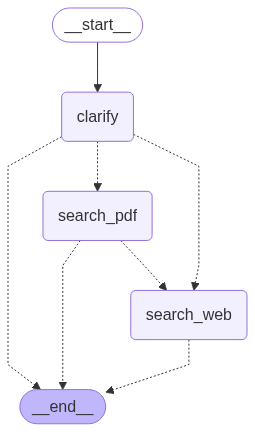

In [9]:
workflow.add_edge(START, "clarify")
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [85]:
events = graph.stream(
    {
        "messages": [
            {
                "role" : "user",
                "content" : "What is the t5 model finetuned on?"
            }
        ],
    },
)
for s in events:
    print(s)
    print("----")

KeyboardInterrupt: 

In [4]:
response = graph.invoke({"messages" : [{"role":"user","content":"What execution accuracy does davinci-codex reach on Spider with the 'Create Table + Select 3' prompt?"}]})
response["messages"][-1].content

NameError: name 'graph' is not defined

In [101]:
print(search_vectorDB("What execution accuracy does davinci-codex reach on Spider with the 'Create Table + Select 3' prompt?"))

Table 3: EX (%) of 8 zero-shot prompt templates on Spider dev set.
Source: Zhang et al. - 2024 - Benchmarking the Text-to-SQL Capability of Large L.pdf - p. 7
Title: 4.1.1 Zero-shot Prompting Optimization.

(60.0). davinci, TS = 53.9 (42.1). davinci, Prompt = + 10 Rows. davinci, VA = 91.2 (90.6). davinci, EX = 63.3 (58.3). davinci, TS = 52.4 (40.2)
Table 4: Performance on Spider across all evaluated models and prompts, as measured by percentage of predictions which are valid/executable SQL (VA), execution accuracy (EX), test-suite accuracy (TS). Main results are on the Spider development set, results in parantheses are on Spider-Realistic (Deng et al., 2021), a modified subset of the Spider development set with explicit references to column names removed from questions.
Source: Rajkumar et al. - 2022 - Evaluating the Text-to-SQL Capabilities of Large L.pdf - p. 7
Title: B Additional Tables and Figures

We also consider Ambiguous Correct behaviours which are semantically different from 

In [33]:
response = pdf_agent.invoke({"messages" : [{"role" : "user", "content" : "Which prompt template gave the highest zero-shot accuracy on Spider in Zhang et al. (2024)?"}]})
for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

Which prompt template gave the highest zero-shot accuracy on Spider in Zhang et al. (2024)?
================================== Ai Message ==================================
Tool Calls:
  search_vectorDB (1279ca8f-7c03-4c23-81df-0c6c44aca865)
 Call ID: 1279ca8f-7c03-4c23-81df-0c6c44aca865
  Args:
    num_results: 10
    query: Zhang et al. 2024 Spider zero-shot accuracy
================================= Tool Message =================================
Name: search_vectorDB

Table 3: EX (%) of 8 zero-shot prompt templates on Spider dev set.
Source: Zhang et al. - 2024 - Benchmarking the Text-to-SQL Capability of Large L.pdf - p. 7
Title: 4.1.1 Zero-shot Prompting Optimization.

Shuaichen Chang and Eric Fosler-Lussier The Ohio State University {chang.1692, fosler-lussier.1}@osu.edu
Source: Chang and Fosler-Lussier - 2023 - How to Prompt LLMs for Text-to-SQL A Study in Zer.pdf - p. 1
Title: How to Prompt LLMs f

In [94]:
response = web_agent.invoke({"messages" : [{"role" : "user", "content" : "Who was the 26th president?"}]})
for message in response["messages"]:
    message.pretty_print()

c:\Users\Arm\AppData\Local\Programs\Python\Python312\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\Users\Arm\AppData\Local\Programs\Python\Python312\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(
c:\Users\Arm\AppData\Local\Programs\Python\Python312\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\Users\Arm\AppData\Local\Programs\Python\Python312\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(
c:\Users\Arm\AppData\Local\Programs\Python\Python312\L

================================ Human Message =================================

Who was the 26th president?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (9a79487d-9c19-49b8-8eb5-484cf0466493)
 Call ID: 9a79487d-9c19-49b8-8eb5-484cf0466493
  Args:
    query: 26th president
================================= Tool Message =================================
Name: duckduckgo_search

No good DuckDuckGo Search Result was found
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (82f82f7b-03aa-421f-8e2a-f6a3baa56ca4)
 Call ID: 82f82f7b-03aa-421f-8e2a-f6a3baa56ca4
  Args:
    query: who was the 26th president of the united states
================================= Tool Message =================================
Name: duckduckgo_search

No good DuckDuckGo Search Result was found
================================== Ai Message ==================================
Tool Calls:


In [33]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

what's the combined headcount of the FAANG companies in 2024?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_pdf_agent (fb104001-9a67-4f7e-99a9-e14695a095a4)
 Call ID: fb104001-9a67-4f7e-99a9-e14695a095a4
  Args:
    query: combined headcount of FAANG companies in 2024
================================= Tool Message =================================
Name: transfer_to_pdf_agent

Successfully transferred to pdf_agent
================================== Ai Message ==================================
Name: pdf_agent

Based on the tool call response, I was unable to retrieve the information requested.

However, I can suggest some possible sources where you may be able to find the combined headcount of the FAANG companies in 2024:

1. Company annual reports: You can check the annual reports of each FAANG company (Facebook, Apple, Amazon, 